In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from collections import OrderedDict

In [2]:
#-----------------------------------------------------------------------#
#----------------------------- [ Function ] ----------------------------#
#-----------------------------------------------------------------------#
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
def relu(x):
    return np.maximum(0, x)

In [3]:
#-----------------------------------------------------------------------#
#------------------------------ [ Layer ] ------------------------------#
#-----------------------------------------------------------------------#
class Relu:
    def __init__(self):
        self.mask = None
        return
    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx
class Sigmoid:
    def __init__(self):
        self.out = None
        return
    def forward(self, x):
        out = 1/(1+np.exp(-x))
        self.out = out
        return out
    def backward(self, dout):
        dx = dout*(1.0-self.out)*self.out
        return dx
class Affine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.x, self.dW, self.db = None, None, None
        return
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T) #.Tは転置
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        return
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y-self.t) / batch_size
        return dx
class BatchNormalization:
    
    # インスタンス変数の定義
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        
        # 再変換用のパラメータ
        self.gamma = gamma # 標準偏差
        self.beta = beta # 平均
        self.momentum = momentum # 減衰率
        
        # テスト時に使用する統計量
        self.running_mean = running_mean # 平均
        self.running_var = running_var # 分散 
        
        # 逆伝播時に使用する統計量
        self.batch_size = None # データ数
        self.xc = None # 偏差
        self.std = None # 標準偏差
        self.dgamma = None # (再変換用の)標準偏差の微分
        self.dbeta = None # (再変換用の)平均の微分
    
    # 順伝播メソッドの定義
    def forward(self, x, train_flg=True):
        # 初期値を与える
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg: # 学習時
            # 正規化の計算
            mu = x.mean(axis=0) # 平均
            xc = x - mu # 偏差
            var = np.mean(xc ** 2, axis=0) # 分散
            std = np.sqrt(var + 10e-7) # 標準偏差
            xn = xc / std # 標準化:式(6.7)
            
            # 計算結果を(逆伝播用に)インスタンス変数として保存
            self.batch_size = x.shape[0]
            self.xc = xc # 偏差
            self.xn = xn # 標準化データ
            self.std = std # 標準偏差
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu # 過去の平均の情報
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var # 過去の分散の情報
            
        else: # テスト時
            xc = x - self.running_mean
            xn = xc / np.sqrt(self.running_var + 10e-7) # 標準化:式(6.7')
        
        # 再変換
        
        out = self.gamma * xn + self.beta # 式(6.8)
        return out
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        
        # 微分の計算
        dbeta = dout.sum(axis=0) # 調整後の平均
        dgamma = np.sum(self.xn * dout, axis=0) # 調整後の標準偏差
        dxn = self.gamma * dout # 正規化後のデータ
        dxc = dxn / self.std # 偏差
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0) # 標準偏差
        dvar = 0.5 * dstd / self.std # 分散
        dxc += (2.0 / self.batch_size) * self.xc * dvar # 偏差
        dmu = np.sum(dxc, axis=0) # 平均
        dx = dxc - dmu / self.batch_size # 入力データ
        
        # インスタンス変数に保存
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [4]:
#-----------------------------------------------------------------------#
#-------------------------- [ MultiLayerNet ] --------------------------#
#-----------------------------------------------------------------------#
class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size, \
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0.1, \
                 use_batchnorm=False, use_dropout=False, dropout_ration = 0.5):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
        # Initial Condition of Weight and Bias #
        self.params = {}
        all_size_list = [self.input_size]+self.hidden_size_list+[self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std # relu or sigmoid #
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
                
            self.params['W'+str(idx)] = scale*np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b'+str(idx)] = np.zeros(all_size_list[idx])
            
        
        # Layer Generation #
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            # Affine Layer #
            self.layers['Affine'+str(idx)] = Affine(self.params['W'+str(idx)], self.params['b'+str(idx)])
            
            # Batch Layer #
            if self.use_batchnorm:
                self.params['gamma'+str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta'+str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm'+str(idx)] = \
                BatchNormalization(self.params['gamma'+str(idx)], self.params['beta'+str(idx)])
                
            # Activation Layer #
            self.layers['Activation_function'+str(idx)] = activation_layer[activation]()
            
            # Dropout #
            if self.use_dropout:
                self.layers['Dropout'+str(idx)] = Dropout(dropout_ration)
            
        # Last Affine Layer #
        idx = self.hidden_layer_num + 1
        self.layers['Affine'+str(idx)] = Affine(self.params['W'+str(idx)], self.params['b'+str(idx)])
        
        # Softmax With Loss Layer #
        self.lastLayer = SoftmaxWithLoss()
        
        return
    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x
    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num+2):
            W = self.params['W'+str(idx)]
            weight_decay += 0.5*self.weight_decay_lambda*np.sum(W**2)
        return self.lastLayer.forward(y, t) + weight_decay
    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        
        # 推論結果を抽出(最大値のインデックスを取得)
        if y.ndim == 2: # 2次元配列(バッチデータ)のとき
            y = np.argmax(y, axis=1)
            t = np.argmax(t, axis=1)
        elif y.ndim == 1: # 1次元配列(データが1つ)のとき
            y = np.argmax(y)
            t = np.argmax(t)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def gradient(self, x, t):
        # forward #
        self.loss(x, t, train_flg=True)
        
        # backward #
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 計算結果をディクショナリ変数に格納
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2): # (`+2`は未満に対応するためと最終レイヤの分)
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num + 1: # 最終層以外のとき
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta
        
        return grads

In [5]:
#-----------------------------------------------------------------------#
#---------------------------- [ Optimizer ] ----------------------------#
#-----------------------------------------------------------------------#
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        return
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]
        return
class Momentum:
    def __init__(self, lr=0.1, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        return
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]
        return
class AdaGrad:
    def __init__(self, lr=0.1):
        self.lr = lr
        self.h = None
        return
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr*grads[key] / ( np.sqrt(self.h[key])+1e-7 )
        return
class Adam:
    # インスタンス変数を定義
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr # 学習率
        self.beta1 = beta1 # mの減衰率
        self.beta2 = beta2 # vの減衰率
        self.iter = 0 # 試行回数を初期化
        self.m = None # モーメンタム
        self.v = None # 適合的な学習係数
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # mとvを初期化
        if self.m is None: # 初回のみ
            self.m = {}
            self.v = {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val) # 全ての要素が0
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        self.iter += 1 # 更新回数をカウント
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter) # 式(6)の学習率の項
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key] # 式(1)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # 式(2)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # 式(6)

In [9]:
# Read Data Set #
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# Instaniation of MultiLayerNet #
network = MultiLayerNet(input_size=784, hidden_size_list=[100,100], output_size=10, \
                        activation='relu', weight_init_std='relu', weight_decay_lambda=0.0, \
                        use_batchnorm=False, use_dropout=False, dropout_ration = 0.5)

# Parameter #
iters_num = 10000  # 実行回数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list, train_acc_list, test_acc_list = [], [], []
iter_per_epoch = max(train_size / batch_size, 1)

# Instaniation of Optimizer #
#optimizer = SGD(learning_rate)
#optimizer = Momentum()
#optimizer = AdaGrad()
optimizer = Adam()


for i in range(iters_num):
    # Data Selection #
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # Gradient Calculation #
    grads = network.gradient(x_batch, t_batch)
    
    # Dictional(instance variables) of weight and bias #
    params = network.params
    
    # Parameter Update #
    optimizer.update(params, grads)
    
    # Loss Calculation #
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # Acurracy Calculation #
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.12091666666666667, 0.1242
train acc, test acc | 0.95715, 0.9558
train acc, test acc | 0.97325, 0.967
train acc, test acc | 0.9744666666666667, 0.965
train acc, test acc | 0.98095, 0.9701
train acc, test acc | 0.9871166666666666, 0.9762
train acc, test acc | 0.99085, 0.9784
train acc, test acc | 0.9876833333333334, 0.9724
train acc, test acc | 0.9924833333333334, 0.9776
train acc, test acc | 0.9922333333333333, 0.9757
train acc, test acc | 0.99465, 0.9774
train acc, test acc | 0.9934833333333334, 0.977
train acc, test acc | 0.99425, 0.9758
train acc, test acc | 0.9967666666666667, 0.9795
train acc, test acc | 0.99705, 0.9805
train acc, test acc | 0.9983166666666666, 0.9806
train acc, test acc | 0.9965, 0.9776


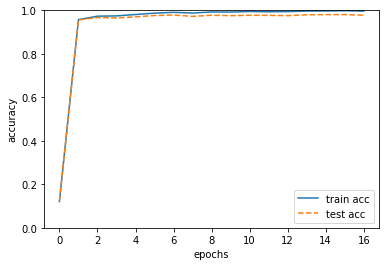

In [10]:
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [8]:
print(network.layers)
np.set_printoptions(threshold=np.inf)
print(grads['W1'])
print(np.get_printoptions()['threshold'])

OrderedDict([('Affine1', <__main__.Affine object at 0x0000019735224250>), ('Activation_function1', <__main__.Relu object at 0x0000019735224460>), ('Affine2', <__main__.Affine object at 0x0000019735224E50>), ('Activation_function2', <__main__.Relu object at 0x0000019735224490>), ('Affine3', <__main__.Affine object at 0x0000019735224FD0>)])
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00